# Autoregressive Model Testing

## Notes for revision:
- Use ADF to determine if the data is stationary
- If the data is not stationary, use ACF， PACF to determine the difference
- AR(order, difference, moving average), start with order 1
- Issue: negative R^2 meaning the model is not converging

RMSE reduced by: 
- 13.19% by adding Bitcoin volitility in GDP AR prediction
- 10.86% by adding USD Coin volitility in GDP AR prediction


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [3]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Testing all combinations

In [4]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
order = 1
train_end = '2023-05-01'
train_start = '2017-09-01'

results_list = []

In [5]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()


In [6]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

### Check that all macro has been differenced appropriately 

In [7]:
for macro in macro_list:
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro
    
    check_stationarity(df[target_col]) 

ADF test for LFPR_diff: p-value = 0.0000
ADF test for CPI_diff_diff: p-value = 0.0000
ADF test for r_diff_diff: p-value = 0.0000
ADF test for M1_diff: p-value = 0.0000
ADF test for GDP Monthly_diff: p-value = 0.0000
ADF test for IM_diff: p-value = 0.0000
ADF test for EX_diff: p-value = 0.0000
ADF test for CC_diff: p-value = 0.0000
ADF test for CC Monthly % Change: p-value = 0.0000
ADF test for VIX: p-value = 0.0005
ADF test for MOVE_diff: p-value = 0.0000


In [8]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [9]:
# variable = 'CPI'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# diff(df, variable)
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# diff(df, variable)
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

In [10]:
def run_model(df, macro, asset, MA):
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro

    df_temp = df[[target_col, asset]].dropna().copy()
    target = df_temp[target_col]
    exog = df_temp[[asset]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    # AR model
    ar_model = SARIMAX(train_endog, order=(order, 0, MA))
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(order, 0, MA))
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar)
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx)
        }
    ]

    return metrics

In [11]:
MA = 0
results_list = []
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset, MA)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2
0,AR,LFPR,Bitcoin,0.0667,0.1069,0.0000
1,ARX,LFPR,Bitcoin,0.0696,0.1071,-0.0028
2,AR,LFPR,Tether,0.0667,0.1069,0.0000
3,ARX,LFPR,Tether,0.0697,0.1072,-0.0047
4,AR,LFPR,Litecoin,0.0667,0.1069,0.0000
5,ARX,LFPR,Litecoin,0.0760,0.1098,-0.0555
6,AR,LFPR,XRP,0.0667,0.1069,0.0000
7,ARX,LFPR,XRP,0.0723,0.1083,-0.0256
8,AR,LFPR,Ethereum,0.0667,0.1069,0.0000
9,ARX,LFPR,Ethereum,0.0750,0.1083,-0.0263


# Combinations Where Adding Asset Data Improves the Model

In [12]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
20,CPI,Cardano,0.5838,0.5812,0.7738,0.7721,-0.0148,-0.0103
26,CPI,XRP,0.5840,0.5823,0.7740,0.7732,-0.0153,-0.0132
36,GDP Monthly,Bitcoin,83.2338,71.6158,105.2649,93.0428,-0.2866,-0.0051
38,GDP Monthly,Cardano,83.2468,74.6966,105.2743,95.5761,-0.2868,-0.0606
39,GDP Monthly,Dogecoin,83.2338,74.5177,105.2649,94.7431,-0.2866,-0.0422
40,GDP Monthly,Ethereum,83.2338,74.5989,105.2649,101.5328,-0.2866,-0.1970
41,GDP Monthly,Litecoin,83.2338,73.1161,105.2649,97.8947,-0.2866,-0.1127
42,GDP Monthly,Tether,83.2338,71.3981,105.2649,92.8697,-0.2866,-0.0014
43,GDP Monthly,USD Coin,83.2453,71.5113,105.2732,93.5831,-0.2868,-0.0169
44,GDP Monthly,XRP,83.2338,73.1537,105.2649,97.3714,-0.2866,-0.1008


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,3.4488,3.4103,-0.0037,-0.0414
2,CC,Cardano,3.4477,3.3807,-0.0032,-0.0474
3,CC,Dogecoin,3.4488,3.4147,-0.0037,-0.0475
4,CC,Ethereum,3.4488,3.4003,-0.0037,-0.0458
5,CC,Litecoin,3.4488,3.4212,-0.0037,-0.0597
6,CC,Tether,3.4488,3.4179,-0.0037,-0.0678
7,CC,USD Coin,3.4453,3.4019,-0.0021,-0.0521
8,CC,XRP,3.4488,3.4336,-0.0037,-0.0515
9,CC Monthly % Change,Bitcoin,0.0521,0.0519,-0.0124,-0.0364
10,CC Monthly % Change,Bitcoin Price,0.0521,0.0510,-0.0124,-0.0391


# Testing GDP Volitility

## Plotting Individual Conbination

In [13]:
macro = 'GDP Monthly'
asset = 'Bitcoin Price'
order = 1
MA = 0

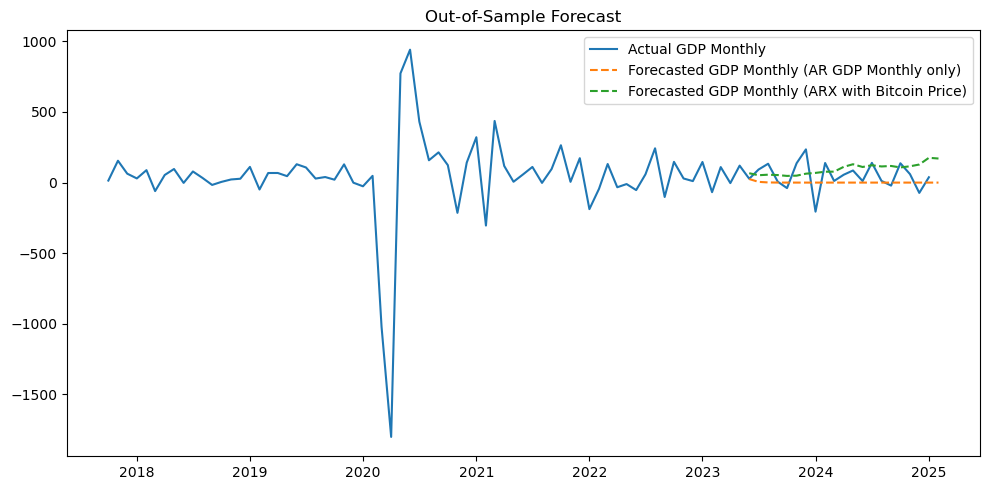

                               SARIMAX Results                                
Dep. Variable:       GDP Monthly_diff   No. Observations:                   68
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -487.246
Date:                Tue, 17 Jun 2025   AIC                            978.491
Time:                        17:06:03   BIC                            982.930
Sample:                    10-01-2017   HQIC                           980.250
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2086      0.037      5.665      0.000       0.136       0.281
sigma2      9.795e+04   6510.356     15.045      0.000    8.52e+04    1.11e+05
Ljung-Box (L1) (Q):                   0.26   Jarque-

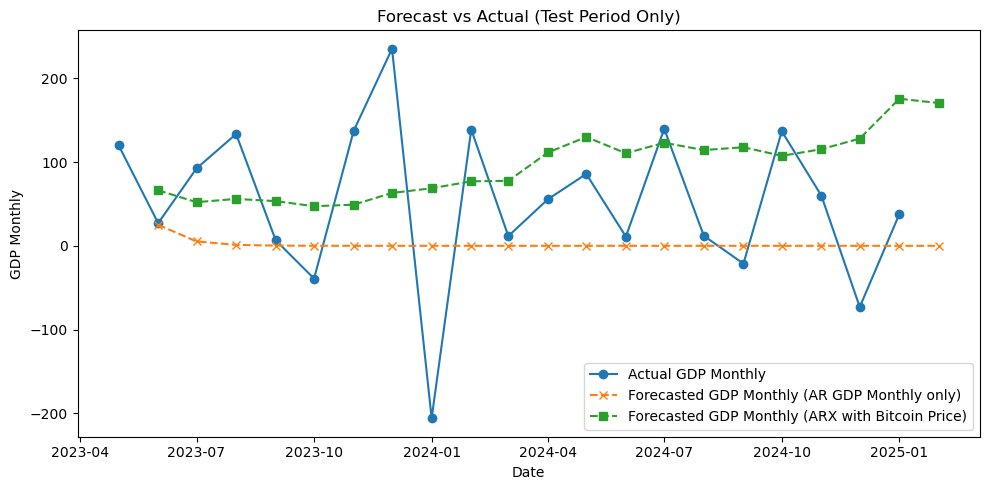

In [14]:
available_cols = df.columns
if f'{macro}_diff_diff' in available_cols:
    target_col = f'{macro}_diff_diff'
elif f'{macro}_diff' in available_cols:
    target_col = f'{macro}_diff'
else:
    target_col = macro

df_temp = df[[target_col, asset]].dropna().copy()

### new
# df_temp['asset_lag1'] = df_temp[asset].shift(1)  # t-1
# df_temp['asset_lag2'] = df_temp[asset].shift(2)  # t-2 (optional)
# df_temp = df_temp.dropna()

target = df_temp[target_col]

exog = df_temp[[asset]]
# exog = df_temp[[asset, 'asset_lag1']].dropna()
# exog = df_temp[[asset, 'asset_lag1','asset_lag2']].dropna()
# exog = df_temp[[asset, 'LFPR', 'r']].dropna()


# Train/test split
train_endog = target[:train_end]
test_endog = target[train_end:]
train_exog = exog[:train_end]
test_exog = exog[train_end:]

# AR model
ar_model = SARIMAX(train_endog, order=(order, 0, MA))
ar_result = ar_model.fit(disp=False)
forecast_ar = ar_result.get_forecast(steps=len(test_endog))
pred_ar = forecast_ar.predicted_mean
conf_int_ar = forecast_ar.conf_int() 

# ARX model
arx_model = SARIMAX(train_endog, exog=train_exog, order=(order, 0, MA))
arx_result = arx_model.fit(disp=False)
forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
pred_arx = forecast_arx.predicted_mean
conf_int_arx = forecast_arx.conf_int()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro)
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--')
# plt.fill_between(
#     pred_ar.index,
#     conf_int_ar.iloc[:, 0],  # Lower bound
#     conf_int_ar.iloc[:, 1],   # Upper bound
#     color='blue',
#     alpha=0.1,
#     label='AR 95% CI'
# )
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--')
# plt.fill_between(
#     pred_arx.index,
#     conf_int_arx.iloc[:, 0],  # Lower bound
#     conf_int_arx.iloc[:, 1],  # Upper bound
#     color='red',
#     alpha=0.1,
#     label='ARX 95% CI'
# )
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Printing stats 
mae_ar = mean_absolute_error(test_endog, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_endog, pred_ar))
r2_ar = r2_score(test_endog, pred_ar)
print(ar_result.summary())
print(arx_result.summary())

mae_arx = mean_absolute_error(test_endog, pred_arx)
rmse_arx = np.sqrt(mean_squared_error(test_endog, pred_arx))
r2_arx = r2_score(test_endog, pred_arx)

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")

# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()